In [2]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Central_Area'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 4104


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128159,CENTRAL AREA,2 ROOM,10,JLN KUKOH,53.0,Improved,1971,48 years 01 month,308000.0,11.0,65.0
128160,CENTRAL AREA,3 ROOM,10,JLN KUKOH,76.0,Improved,1971,48 years 01 month,415000.0,11.0,65.0
128161,CENTRAL AREA,3 ROOM,30,KELANTAN RD,65.0,Improved,1981,58 years 02 months,420000.0,11.0,65.0
128162,CENTRAL AREA,3 ROOM,269A,QUEEN ST,67.0,New Generation,1984,60 years 11 months,465000.0,5.0,65.0
128163,CENTRAL AREA,3 ROOM,335A,SMITH ST,73.0,Improved,1984,60 years 10 months,480000.0,8.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152699,CENTRAL AREA,4 ROOM,1A,CANTONMENT RD,94.0,Type S1,2011,86 years 09 months,1218000.0,32.0,76.0
152700,CENTRAL AREA,4 ROOM,1E,CANTONMENT RD,93.0,Type S1,2011,86 years 09 months,1270000.0,44.0,76.0
152701,CENTRAL AREA,4 ROOM,1E,CANTONMENT RD,94.0,Type S1,2011,86 years 08 months,1238000.0,26.0,76.0
152702,CENTRAL AREA,4 ROOM,53,CHIN SWEE RD,77.0,Improved,1974,50 years 02 months,505000.0,14.0,76.0


In [3]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 4104
check 10 JLN KUKOH. 10 Jln Tambur, Singapore. confidence of 0.8
10 of 57
20 of 57
check 9 JLN KUKOH. 9 Jln Seruling, Singapore. confidence of 0.8
30 of 57
check 8 JLN KUKOH. 8 Jln Tambur, Singapore. confidence of 0.8
40 of 57
50 of 57
3 errors detected
pickle dumped. 4158


In [7]:
df = df[df.street_name!='JLN KUKOH']
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128161,CENTRAL AREA,3 ROOM,30,KELANTAN RD,65.0,Improved,1981,58 years 02 months,420000.0,11.0,65.0
128162,CENTRAL AREA,3 ROOM,269A,QUEEN ST,67.0,New Generation,1984,60 years 11 months,465000.0,5.0,65.0
128163,CENTRAL AREA,3 ROOM,335A,SMITH ST,73.0,Improved,1984,60 years 10 months,480000.0,8.0,65.0
128164,CENTRAL AREA,3 ROOM,2,TG PAGAR PLAZA,59.0,Improved,1977,53 years 09 months,440000.0,5.0,65.0
128165,CENTRAL AREA,3 ROOM,34,UPP CROSS ST,65.0,Improved,1975,52 years 01 month,420000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152699,CENTRAL AREA,4 ROOM,1A,CANTONMENT RD,94.0,Type S1,2011,86 years 09 months,1218000.0,32.0,76.0
152700,CENTRAL AREA,4 ROOM,1E,CANTONMENT RD,93.0,Type S1,2011,86 years 09 months,1270000.0,44.0,76.0
152701,CENTRAL AREA,4 ROOM,1E,CANTONMENT RD,94.0,Type S1,2011,86 years 08 months,1238000.0,26.0,76.0
152702,CENTRAL AREA,4 ROOM,53,CHIN SWEE RD,77.0,Improved,1974,50 years 02 months,505000.0,14.0,76.0


In [8]:
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128161,CENTRAL AREA,3 ROOM,30,KELANTAN RD,65.0,Improved,1981,58 years 02 months,420000.0,11.0,65.0
128162,CENTRAL AREA,3 ROOM,269A,QUEEN ST,67.0,New Generation,1984,60 years 11 months,465000.0,5.0,65.0
128163,CENTRAL AREA,3 ROOM,335A,SMITH ST,73.0,Improved,1984,60 years 10 months,480000.0,8.0,65.0
128164,CENTRAL AREA,3 ROOM,2,TG PAGAR PLAZA,59.0,Improved,1977,53 years 09 months,440000.0,5.0,65.0
128165,CENTRAL AREA,3 ROOM,34,UPP CROSS ST,65.0,Improved,1975,52 years 01 month,420000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152699,CENTRAL AREA,4 ROOM,1A,CANTONMENT RD,94.0,Type S1,2011,86 years 09 months,1218000.0,32.0,76.0
152700,CENTRAL AREA,4 ROOM,1E,CANTONMENT RD,93.0,Type S1,2011,86 years 09 months,1270000.0,44.0,76.0
152701,CENTRAL AREA,4 ROOM,1E,CANTONMENT RD,94.0,Type S1,2011,86 years 08 months,1238000.0,26.0,76.0
152702,CENTRAL AREA,4 ROOM,53,CHIN SWEE RD,77.0,Improved,1974,50 years 02 months,505000.0,14.0,76.0


In [10]:
df = df.copy()

In [11]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,192.000000,192.000000,1.920000e+02,192.00000,192.000000,192.000000,192.000000
mean,80.833333,1988.989583,7.113270e+05,15.68750,70.161458,103.847165,1.289959
std,19.093414,14.635891,3.173900e+05,11.26112,3.295241,0.005802,0.013318
min,45.000000,1974.000000,3.280000e+05,2.00000,65.000000,103.841187,1.274820
25%,64.500000,1977.750000,4.600000e+05,8.00000,67.750000,103.841187,1.276031
50%,82.000000,1983.000000,5.725000e+05,11.00000,70.000000,103.843406,1.285743
75%,94.000000,2011.000000,1.000000e+06,20.00000,73.000000,103.852285,1.303334
max,141.000000,2011.000000,1.400000e+06,50.00000,76.000000,103.857368,1.308831


SuggestedLRs(valley=0.0012022644514217973, slide=6.309573450380412e-07)

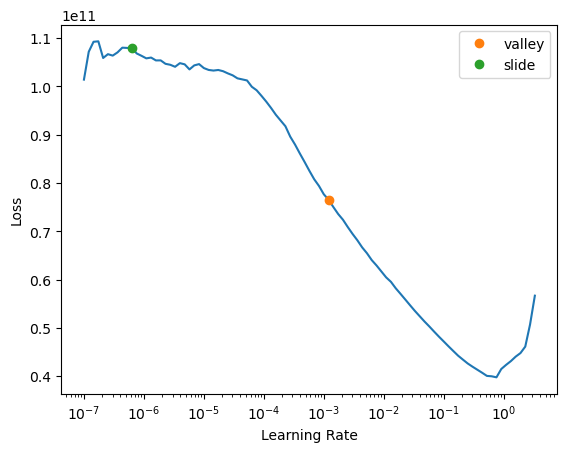

In [13]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [20]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,1e-1)
learn.validate()


Better model found at epoch 0 with valid_loss value: 67010.3046875.


(#2) [4490380800.0,67010.3046875]

In [21]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 2*40
n2 = 4*40
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 160
10 of 160
20 of 160
30 of 160
40 of 160
50 of 160
60 of 160
70 of 160
80 of 160
90 of 160
100 of 160
110 of 160
120 of 160
130 of 160
140 of 160
150 of 160


In [22]:
import http.client, urllib.parse
import json

mrts = ["Dhoby Ghaut MRT", "City Hall MRT", "Raffles Place MRT", "Tanjong Pagar MRT", "Bugis MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 4570
Dhoby Ghaut Station, Singapore, confidence 1
City Hall Station Exit B, Singapore, confidence 1
check Raffles Place MRT. Raffles Place Stn Exit F, Singapore. confidence of 0.8
Former Tanjong Pagar Railway Station, Singapore, confidence 1
Bugis Station, Singapore, confidence 1
pickle dumped. 4574


In [24]:
longLats['Raffles Place MRT'] = (responses[2]['longitude'], responses[2]['latitude'])
dump_pkl(longLats)

pickle dumped. 4575


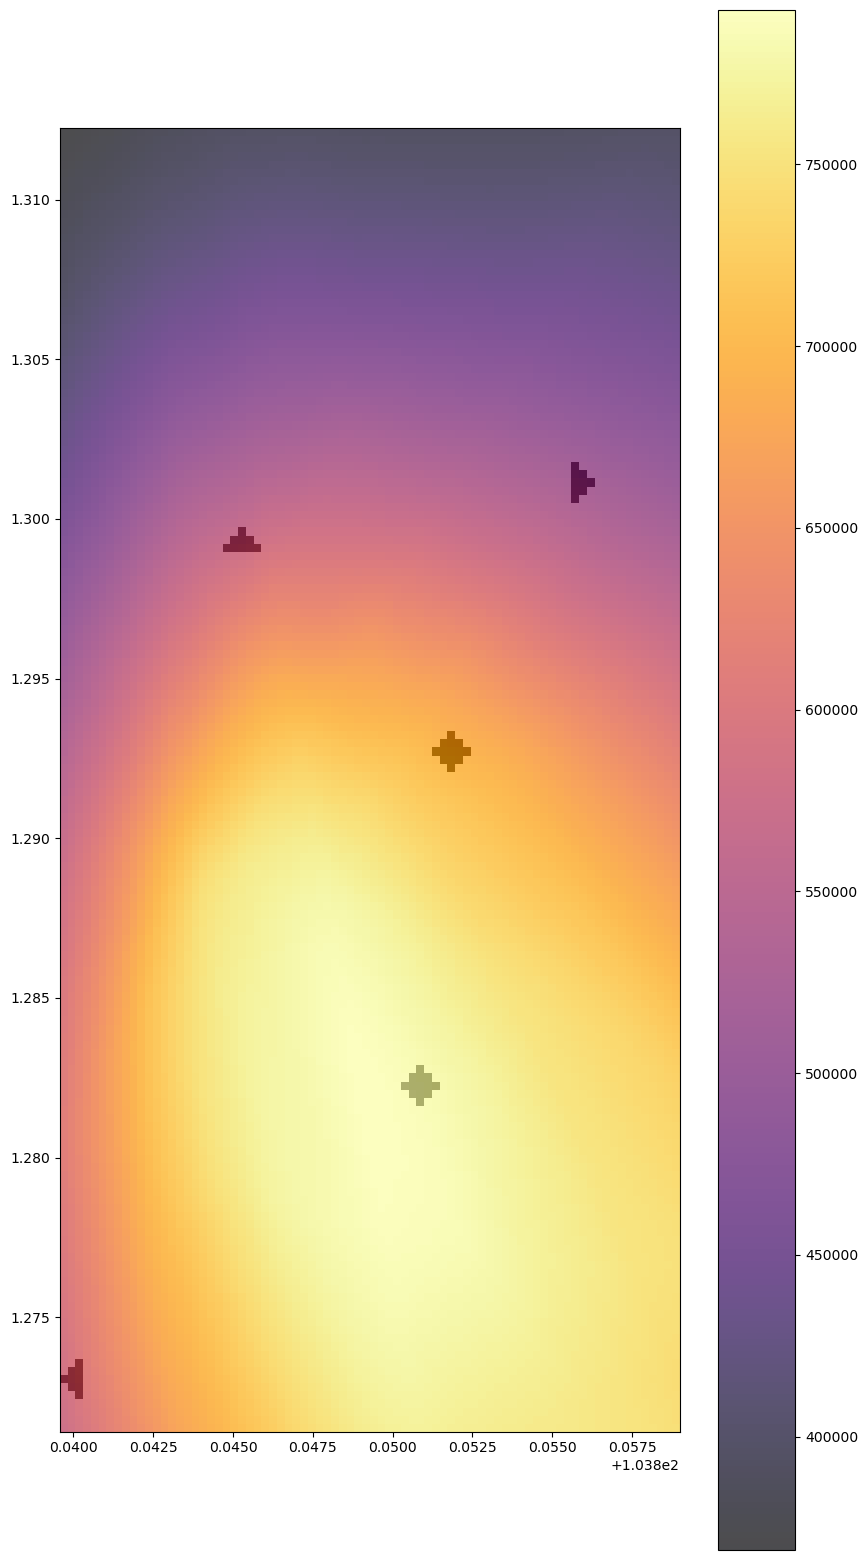

In [29]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_up(*min_coords(*longLats[mrts[0]]))
map_star(*min_coords(*longLats[mrts[1]]))
map_star(*min_coords(*longLats[mrts[2]]))
#map_left(*min_coords(*longLats[mrts[3]]))
(i,j) = min_coords(*longLats[mrts[3]])
map_left(i+1,j)
map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

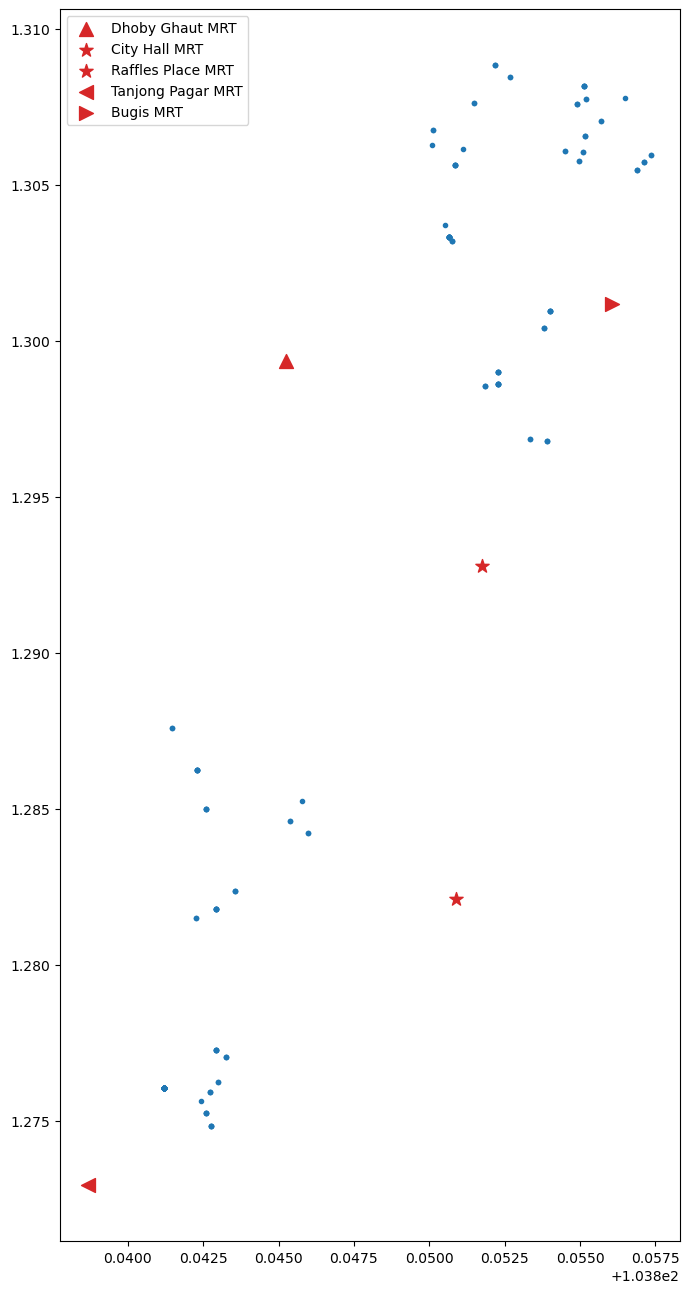

In [30]:
markers = ["^", '*', "*", '<', '>', '^', '^']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
